# **Writing Score model**

## Objectives

- Train and evaluate a model for predicting a student's writing score

## Inputs

- outputs/datasets/filtered/writing-score-dataset.csv
- outputs/datasets/split/writing/writing-test-score.csv
- outputs/datasets/split/writing/writing-train-score.csv
- outputs/datasets/split/writing/writing-test-vars.csv
- outputs/datasets/split/writing/writing-train-vars.csv

## Outputs

- A pipeline to predict a student's reading score

## Additional comments

# Change working directory

Since this notebook exists in the jupyter_notebooks directory, we need to change the current working directory from the jupyter_notebooks directory to the workspace, so that any directories created in further codes cells are added in the correct place. 

We access the current directory with the OS packages' `getcwd()` method

In [1]:
import os
current_directory = os.getcwd()
current_directory


'/workspace/Exam-Scores-Analysis/jupyter_notebooks'

We now want to set the working directory as the parent of the current working directory, jupyter_notebooks

- The `os.path.dirname()` method gets the parent directory
- The `os.chir()` method defines the new current directory
- We do this to access all of the project's files and directories, rather than those in the jupyter_notebooks directory

In [2]:
os.chdir(os.path.dirname(current_directory))
print("You set a new current directory")

You set a new current directory


To make certain of things, we now use a code cell to confirm that we have set the current working directory properly

In [3]:
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis'

Import packages:

In [4]:
### Standard Data Science modules:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

### SciKit Learn modules
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Writing Score Pipeline

The dataset's writing_score variable is a continuous numerical variable, like the math_score and reading_score variables. Given this, as we noted in the reading_score pipeline notebook, we would normally expect to fit a regression model. However, as we saw in those previous notebooks, regression models perform poorly. Therefore, as with the reading_score pipeline notebook, we shall convert to a classification task from the start, as classification algorithms fitted on binned datasets have showed good (but not spectacular) performance.

First, we must load the appropriate dataset:

In [5]:
df_writing = pd.read_csv('outputs/datasets/filtered/writing-score-dataset.csv')
df_writing

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,writing_score
0,male,group A,high school,standard,completed,63
1,female,group D,some high school,free/reduced,none,55
2,male,group E,some college,free/reduced,none,50
3,male,group B,high school,standard,none,68
4,male,group E,associate's degree,standard,completed,68
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,65
996,male,group D,associate's degree,free/reduced,completed,92
997,female,group C,some high school,free/reduced,none,41
998,female,group C,some college,standard,none,82


We can now sort the writing_score variable into bins. As with the previous 2 classification tasks, we will consider 3 and 4 bin approaches, with a view that 3 bins will probably be the superior approach, given previous results. We could proceed solely with the 3 bin approach, as we have used that for the other classification tasks, but we must approach the writing_score classification task independently, and it may turn out that the 4 bin approach is superior.

* The classes represent the following ranges: 
{'writing_score': [-inf, 62.0, 75.0, inf]} 



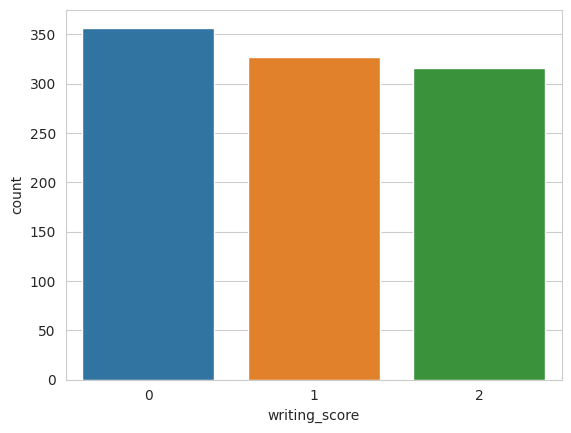

In [6]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

disc_efd_3 = EqualFrequencyDiscretiser(q=3, variables=['writing_score'])
df_writing_clf_efd_3 = disc_efd_3.fit_transform(df_writing)

print(f"* The classes represent the following ranges: \n{disc_efd_3.binner_dict_} \n")
sns.countplot(data=df_writing_clf_efd_3, x='writing_score')
plt.show()

Seems to be evenly distributed. As with the previous classification tasks, the widths of the bins are different:
- Less than 62
- 62 to 75
- Greater than 75

We should see what using 4 bins produces:

* The classes represent the following ranges: 
{'writing_score': [-inf, 58.0, 68.0, 79.0, inf]} 



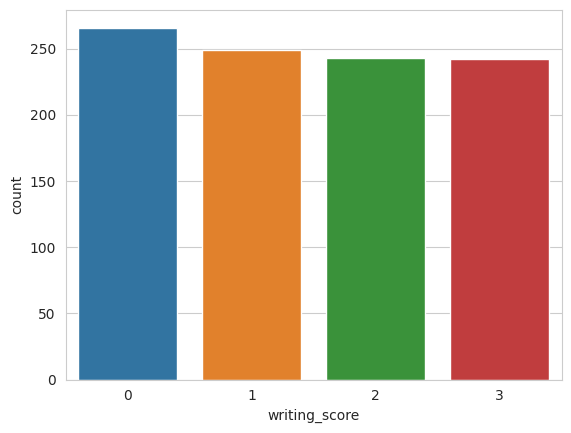

In [7]:
disc_efd_4 = EqualFrequencyDiscretiser(q=4, variables=['writing_score'])
df_writing_clf_efd_4 = disc_efd_4.fit_transform(df_writing)

print(f"* The classes represent the following ranges: \n{disc_efd_4.binner_dict_} \n")
sns.countplot(data=df_writing_clf_efd_4, x='writing_score')
plt.show()

We appear to have 4 bins of approximately equal width:
- Less than 58
- 58 to 67
- 68 to 79
- Greater than 79

As with the math_score and reading_score notebooks, we'll fit and evaluate pipelines with both discretised datasets, to see which performs best. 

In the math_score notebook, we briefly tried using the equal width discretiser, with extremely inbalanced results. Exploring that alternative for writing_score is probably futile. 

We'll begin with the 3-bin dataset:

In [8]:
df_writing_clf_efd_3

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,writing_score
0,male,group A,high school,standard,completed,1
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,1
4,male,group E,associate's degree,standard,completed,1
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,1
996,male,group D,associate's degree,free/reduced,completed,2
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,2


We'll construct the pipeline:

In [13]:
def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['gender', 'ethnicity', 'parental_education', 'lunch_program', 'test_preparation_course'] ) ),
       

      ("feature_scaling", StandardScaler() ),

      ("feature_selection",  SelectFromModel(model) ),

      ("model", model ),
       
    ])

  return pipeline_base

Now we split the discretised dataset into train and test sets:

In [9]:
writing_train_vars_3, writing_test_vars_3, writing_train_score_3, writing_test_score_3 = train_test_split(
    df_writing_clf_efd_3.drop(['writing_score'], axis=1),
    df_writing_clf_efd_3['writing_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", writing_train_vars_3.shape, writing_train_score_3.shape, "\n* Test set:",  writing_test_vars_3.shape, writing_test_score_3.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


Now we define the models we want to test, and the default hyperparameters:

In [10]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "SGDClassifier": SGDClassifier(random_state=0),
}

parameters_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
    "SGDClassifier": {},
}

In the reading_score notebook, we tried the NaiveBayesClassifier, Support Vector Machine and KNeighborsClassifier algorithms but ran into problems, we won't include them.

We can now define the standard HyperparameterOptimisationSearch class:

In [11]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

And now we can call it:

In [14]:
model_search_3 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_3.fit(writing_train_vars_3, writing_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Now we inspect the results:

In [15]:
writing_efd_3_model_grid_search_summary, writing_efd_3_model_grid_search_pipelines = model_search_3.score_summary(sort_by='mean_score')
writing_efd_3_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
1,DecisionTreeClassifier,0.482143,0.544805,0.607143,0.043007
4,ExtraTreesClassifier,0.482143,0.544805,0.607143,0.043007
3,GradientBoostingClassifier,0.428571,0.523701,0.636364,0.068932
6,SGDClassifier,0.392857,0.512857,0.607143,0.098706
0,XGBClassifier,0.339286,0.469545,0.607143,0.096094
5,AdaBoostClassifier,0.410714,0.465909,0.535714,0.052523
2,RandomForestClassifier,0.375,0.458831,0.553571,0.058552


Interesting - the DecisionTreeClassifier comes out on top, but the ExtraTreesClassifier has identical results, so we should take both forward for hyperparameter optimisation. In the reading_score notebook, this led to an interesting outcome where the RandomForestClassifier had a significant jump in performance. As with that case, a mean_score of 0.54 isn't overly impressive, but is acceptable, and we will hope that hyperparameter optimisation improves things:

In [16]:
models_3 = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}
 
parameters_3 = {
    "DecisionTreeClassifier": {
                            'model__max_depth': [None, 4, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1, 50],
                            'model__max_leaf_nodes': [None, 50],
                            },

     "ExtraTreesClassifier": {
                            'model__n_estimators': [100,50,150],
                            'model__max_depth': [None, 3, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1,50],
                            }
}

In [17]:
parameters_search_3 = HyperparameterOptimizationSearch(models=models_3, parameters=parameters_3)
parameters_search_3.fit(writing_train_vars_3, writing_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Now we inspect the results:

In [18]:
writing_efd_3_parameters_grid_search_summary, writing_efd_3_parameters_grid_search_pipelines = parameters_search_3.score_summary(sort_by='mean_score')
writing_efd_3_parameters_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
45,ExtraTreesClassifier,0.410714,0.602078,0.696429,0.102771,3,NaN,50,50,100
42,ExtraTreesClassifier,0.410714,0.602078,0.696429,0.102771,3,NaN,50,2,100
47,ExtraTreesClassifier,0.410714,0.602078,0.696429,0.102771,3,NaN,50,50,150
44,ExtraTreesClassifier,0.410714,0.602078,0.696429,0.102771,3,NaN,50,2,150
30,ExtraTreesClassifier,0.410714,0.598506,0.678571,0.099694,None,NaN,50,2,100
33,ExtraTreesClassifier,0.410714,0.598506,0.678571,0.099694,None,NaN,50,50,100
34,ExtraTreesClassifier,0.339286,0.598506,0.714286,0.137359,None,NaN,50,50,50
35,ExtraTreesClassifier,0.410714,0.598506,0.678571,0.099694,None,NaN,50,50,150
43,ExtraTreesClassifier,0.410714,0.598506,0.696429,0.100965,3,NaN,50,2,50
46,ExtraTreesClassifier,0.410714,0.598506,0.696429,0.100965,3,NaN,50,50,50


Excellent - hyperparameter optimisation has significantly improved performance of the ExtraTreesClassifier to 0.60, which is acceptable. 

We can now assess feature importance for the 3-bin approach, and generate a classification report and confusion matrix. First though, we need to save the best model and hyperparameters:

In [19]:
writing_efd_3_best_model = writing_efd_3_parameters_grid_search_summary.iloc[0,0]
writing_efd_3_best_model

'ExtraTreesClassifier'

In [20]:
writing_efd_3_best_parameters = writing_efd_3_parameters_grid_search_pipelines[writing_efd_3_best_model].best_params_
writing_efd_3_best_parameters

{'model__max_depth': 3,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [21]:
writing_efd_3_pipeline_clf = writing_efd_3_parameters_grid_search_pipelines[writing_efd_3_best_model].best_estimator_
writing_efd_3_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(random_state=0))),
                ('model',
                 ExtraTreesClassifier(max_depth=3, min_samples_leaf=50,
                                      random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education']


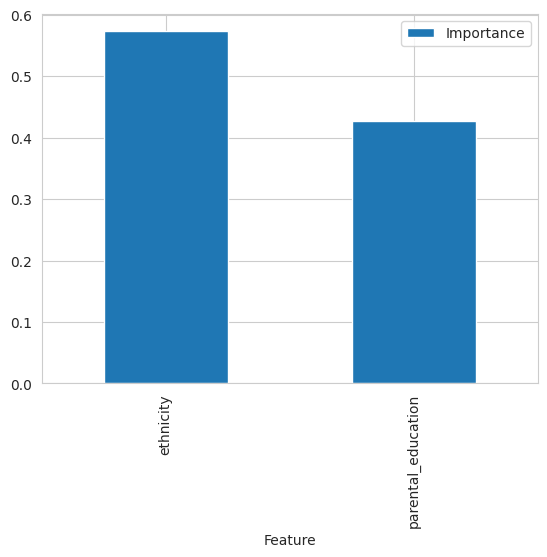

In [23]:
# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(writing_efd_3_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(writing_train_vars_3)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_3 = columns_after_data_cleaning_feat_eng[writing_efd_3_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_3 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[writing_efd_3_pipeline_clf['feature_selection'].get_support()],
          'Importance': writing_efd_3_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

writing_efd_3_best_features = df_feature_importance_3['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_3)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_3}")

df_feature_importance_3.plot(kind='bar',x='Feature',y='Importance')
plt.show()

It appears that the ethnicity and parental_education variables have been identified as the most important variables. This is good - these variables have been identified as the most important features for prediciting the math_score and reading_score variables, which should simplify matters going forward.

Now for the classification report and confusion matrix:

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(writing_train_vars, writing_train_score, writing_test_vars, writing_test_score, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(writing_train_vars_3, writing_train_score_3, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(writing_test_vars_3, writing_test_score_3, pipeline, label_map)

Now we can remind ourselves of the bins:

In [25]:
disc_efd_3.binner_dict_['writing_score']

[-inf, 62.0, 75.0, inf]

Now we can replace the labels with more imformative ones:

In [26]:
writing_efd_3_label_map = ['<62.0', '62 to 75','>75.0']
writing_efd_3_label_map

['<62.0', '62 to 75', '>75.0']

Now for the classification report and confusion matrix:

In [29]:
clf_performance(writing_train_vars_3, writing_train_score_3, writing_test_vars_3, writing_test_score_3, writing_efd_3_pipeline_clf, writing_efd_3_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <62.0 Actual 62 to 75 Actual >75.0
Prediction <62.0             189             150          104
Prediction 62 to 75           20              37           22
Prediction >75.0              70              83          125


---  Classification Report  ---
              precision    recall  f1-score   support

       <62.0       0.43      0.68      0.52       279
    62 to 75       0.47      0.14      0.21       270
       >75.0       0.45      0.50      0.47       251

    accuracy                           0.44       800
   macro avg       0.45      0.44      0.40       800
weighted avg       0.45      0.44      0.40       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual <62.0 Actual 62 to 75 Actual >75.0
Prediction <62.0              55              30           27
Prediction 62 to 75            6               6            8
Prediction >75.0              17              21     

Interesting - as with the previous classification models we have trained, we have good (but not great) performance on the predicting the lowest-scoring class, but weak performance on prediciting the middle-scoring class, and middling performance on predicting the highest-scoring class. As with the previous models, this is acceptable, since the business requirements are for a tool that can predict low-scoring students (or in this case, students who fall into the lowest scoring class)

We can now assess the performance of the 4-bin approach. As above, given performance of the 4-bin approach in the other notebooks, we anticipate poorer performance.

First, we recap the dataset:

In [30]:
df_writing_clf_efd_4

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,writing_score
0,male,group A,high school,standard,completed,1
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,1
4,male,group E,associate's degree,standard,completed,1
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,1
996,male,group D,associate's degree,free/reduced,completed,3
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,3


Now we split the dataset:

In [31]:
writing_train_vars_4, writing_test_vars_4, writing_train_score_4, writing_test_score_4 = train_test_split(
    df_writing_clf_efd_4.drop(['writing_score'], axis=1),
    df_writing_clf_efd_4['writing_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", writing_train_vars_4.shape, writing_train_score_4.shape, "\n* Test set:",  writing_test_vars_4.shape, writing_test_score_4.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


Now we determine the best algorithm to use for the model. We already have the models_quick_search and parameters_quick_search in memory

In [32]:
model_search_4 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_4.fit(writing_train_vars_4, writing_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [33]:
writing_efd_4_model_grid_search_summary, writing_efd_4_model_grid_search_pipelines = model_search_4.score_summary(sort_by='mean_score')
writing_efd_4_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
0,XGBClassifier,0.375,0.45,0.575,0.075829
6,SGDClassifier,0.0,0.435,0.825,0.295635
1,DecisionTreeClassifier,0.25,0.395,0.525,0.096695
3,GradientBoostingClassifier,0.25,0.395,0.6,0.122882
4,ExtraTreesClassifier,0.25,0.395,0.525,0.096695
2,RandomForestClassifier,0.25,0.39,0.5,0.090277
5,AdaBoostClassifier,0.3,0.34,0.4,0.04899


Interesting - we see that the XGBClassifier has performed best, but performance is significantly worse than with the 3 bin approach. We haven't seen the XGBClassifier perform well before.

It is unlikely that hyperparameter optimisation will improve performance enough to rival the ExtraTreesClassifier in the 3-bin approach, but since we have't optimised the XGBClassifier before, we could be surprised.

In [36]:
models_4 = {
    "XGBClassifier":XGBClassifier(random_state=0),
}
 
parameters_4 = {
    "XGBClassifier":{
                    'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
                    }

}

In [37]:
parameters_search_4 = HyperparameterOptimizationSearch(models=models_4, parameters=parameters_4)
parameters_search_4.fit(writing_train_vars_4, writing_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [38]:
writing_efd_4_parameters_grid_search_summary, writing_efd_4_parameters_grid_search_pipelines = parameters_search_4.score_summary(sort_by='mean_score')
writing_efd_4_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__gamma,model__learning_rate,model__max_depth,model__n_estimators
0,XGBClassifier,0.375,0.475,0.7,0.120416,0,0.01,None,30
24,XGBClassifier,0.375,0.475,0.7,0.120416,0,0.001,15,30
26,XGBClassifier,0.375,0.475,0.7,0.120416,0,0.001,15,200
1,XGBClassifier,0.375,0.475,0.7,0.120416,0,0.01,None,80
28,XGBClassifier,0.375,0.475,0.7,0.120416,0.1,0.01,None,80


Disappointing - it appears hyperparameter optimisation has failed to improve performance significantly. We can assess feature importance and generate a classification report and confusion matrix.

In [39]:
writing_efd_4_best_model = writing_efd_4_parameters_grid_search_summary.iloc[0,0]
writing_efd_4_best_model

'XGBClassifier'

In [40]:
writing_efd_4_best_parameters = writing_efd_4_parameters_grid_search_pipelines[writing_efd_4_best_model].best_params_
writing_efd_4_best_parameters

{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': None,
 'model__n_estimators': 30}

In [41]:
writing_efd_4_pipeline_clf = writing_efd_4_parameters_grid_search_pipelines[writing_efd_4_best_model].best_estimator_
writing_efd_4_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_byno...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_chil

Now for the confusion matrix and classification report

* These are the 2 most important features in descending order. The model was trained on them: 
['lunch_program', 'test_preparation_course']


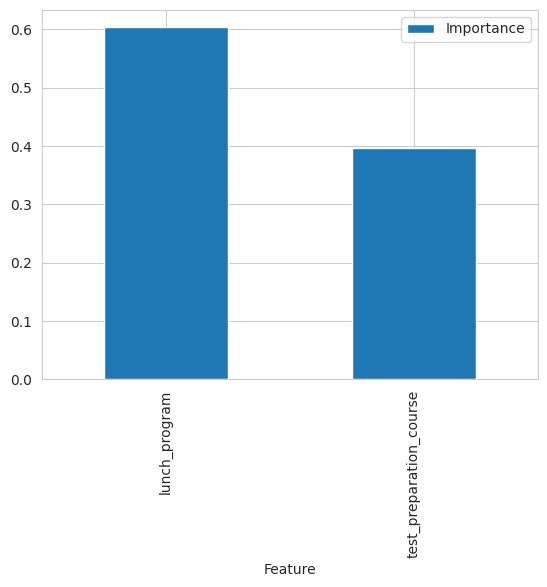

In [42]:
# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(writing_efd_4_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(writing_train_vars_4)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_4 = columns_after_data_cleaning_feat_eng[writing_efd_4_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_4 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[writing_efd_4_pipeline_clf['feature_selection'].get_support()],
          'Importance': writing_efd_4_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

writing_efd_4_best_features = df_feature_importance_4['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_4)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_4}")

df_feature_importance_4.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Interesting - the 4-bin approach has identified the lunch_program and test_preparation_course feature variables as the most important. This is an intriguing outcome, since our data analysis notebooks identified these variables as having good predicitive power and good correlation levels with the target variables. Based on this, we could make an argument that we should accept the 4-bin approach. However, the 3-bin approach has stronger arguments - the model scores higher, and the feature variables used are the same as the other predictive models.

Now for the classification report and confusion matrix:

In [47]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(writing_train_vars, writing_train_score, writing_test_vars, writing_test_score, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(writing_train_vars_4, writing_train_score_4, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(writing_test_vars_4, writing_test_score_4, pipeline, label_map)

In [44]:
disc_efd_4.binner_dict_['writing_score']

[-inf, 58.0, 68.0, 79.0, inf]

In [45]:
writing_efd_4_label_map = ['<58.0', '58 to 67', '68 to 79', '>79.0']
writing_efd_4_label_map

['<58.0', '58 to 67', '68 to 79', '>79.0']

In [48]:
clf_performance(writing_train_vars_4, writing_train_score_4, writing_test_vars_4, writing_test_score_4, writing_efd_4_pipeline_clf, writing_efd_4_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <58.0 Actual 58 to 67 Actual 68 to 79 Actual >79.0
Prediction <58.0              90              47              34           15
Prediction 58 to 67          101             131             106           92
Prediction 68 to 79            0               0               0            0
Prediction >79.0               9              32              55           88


---  Classification Report  ---
              precision    recall  f1-score   support

       <58.0       0.48      0.45      0.47       200
    58 to 67       0.30      0.62      0.41       210
    68 to 79       0.00      0.00      0.00       195
       >79.0       0.48      0.45      0.46       195

    accuracy                           0.39       800
   macro avg       0.32      0.38      0.34       800
weighted avg       0.32      0.39      0.34       800
 

#### Test Set ####



/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---  Confusion Matrix  ---
                    Actual <58.0 Actual 58 to 67 Actual 68 to 79 Actual >79.0
Prediction <58.0              32               8               5            7
Prediction 58 to 67           29              23              28           27
Prediction 68 to 79            0               0               0            0
Prediction >79.0               5               8              15           13


---  Classification Report  ---
              precision    recall  f1-score   support

       <58.0       0.62      0.48      0.54        66
    58 to 67       0.21      0.59      0.32        39
    68 to 79       0.00      0.00      0.00        48
       >79.0       0.32      0.28      0.30        47

    accuracy                           0.34       200
   macro avg       0.29      0.34      0.29       200
weighted avg       0.32      0.34      0.31       200
 



/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Interesting - as with the 4-bin approaches used in the math_score and reading_score approaches, the writing_score 4-bin approach fails to be be able to predict the 68 to 79 class. As in those notebooks, this would acceptable given the reasons above if performance on the lowest-scoring class was sufficient. Unfortunately, it is not. Therefore, we must proceed with the 3-bin approach. We can redefine the pipeline without the feature selection steps, as we have already determined the most important features.

In [49]:
def PipelineOptimization(model):
  pipeline_final = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = [ 'ethnicity', 'parental_education'] ) ),      

      ("feature_scaling", StandardScaler() ),

      ("model", model ),
       
    ])

  return pipeline_final

Because we have used different names for the 3-bin and 4-bin training and test sets, we do not need to resplit the data. We can simply recall those sets and filter them appropriately.

In [50]:
writing_train_score_final = writing_train_score_3
writing_test_score_final = writing_test_score_3

In [51]:
writing_train_vars_final = writing_train_vars_3.filter(writing_efd_3_best_features)
writing_train_vars_final.head()

,ethnicity,parental_education
600,group C,some college
80,group B,bachelor's degree
158,group D,associate's degree
423,group D,associate's degree
747,group A,high school


In [52]:
writing_test_vars_final = writing_test_vars_3.filter(writing_efd_3_best_features)
writing_test_vars_final.head()

,ethnicity,parental_education
778,group C,master's degree
334,group C,high school
271,group D,some high school
802,group B,some college
216,group B,associate's degree


Let's recap the best model and hyperparameters:

In [53]:
writing_efd_3_best_model

'ExtraTreesClassifier'

In [54]:
writing_efd_3_best_parameters

{'model__max_depth': 3,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

We'll now define these manually:

In [57]:
final_model = {
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0)
}

final_parameters = {
    'ExtraTreesClassifier': {
        'model__max_depth': [3],
        'model__min_samples_leaf': [50],
        'model__min_samples_split': [2],
        'model__n_estimators': [100]
        }
}

In [58]:
search_final = HyperparameterOptimizationSearch(models=final_model, parameters=final_parameters)
search_final.fit(writing_train_vars_final, writing_train_score_final,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [59]:
grid_search_summary_writing_final, grid_search_pipelines_writing_final = search_final.score_summary(sort_by='mean_score')
grid_search_summary_writing_final

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesClassifier,0.410714,0.602078,0.696429,0.102771,3,50,2,100


Excellent - it appears model performance is not reduced. We can now check this:

In [61]:
final_writing_model = grid_search_summary_writing_final.iloc[0,0]
final_writing_model

'ExtraTreesClassifier'

In [62]:
pipeline_clf_writing_final = grid_search_pipelines_writing_final[final_writing_model].best_estimator_
pipeline_clf_writing_final

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['ethnicity', 'parental_education'])),
                ('feature_scaling', StandardScaler()),
                ('model',
                 ExtraTreesClassifier(max_depth=3, min_samples_leaf=50,
                                      random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education']


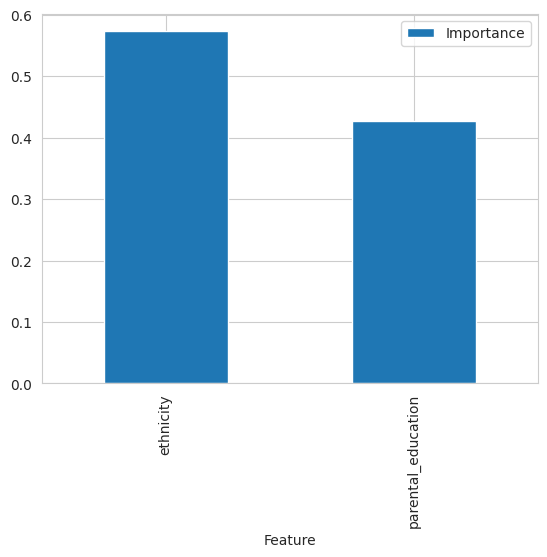

In [63]:
# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_writing_final.steps[:data_cleaning_feat_eng_steps])
                                        .transform(writing_train_vars_final)
                                        .columns)

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf_writing_final['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features_final = df_feature_importance['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_final)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_final}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Excellent - feature importance is unchanged - the 2 most important features are still important.

In [65]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(writing_train_vars, writing_train_score, writing_test_vars, writing_test_score, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(writing_train_vars_final, writing_train_score_final, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(writing_test_vars_final, writing_test_score_final, pipeline, label_map)

In [66]:
clf_performance(writing_train_vars_final, writing_train_score_final, writing_test_vars_final, writing_test_score_final, pipeline_clf_writing_final, writing_efd_3_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <62.0 Actual 62 to 75 Actual >75.0
Prediction <62.0             189             150          104
Prediction 62 to 75           20              37           22
Prediction >75.0              70              83          125


---  Classification Report  ---
              precision    recall  f1-score   support

       <62.0       0.43      0.68      0.52       279
    62 to 75       0.47      0.14      0.21       270
       >75.0       0.45      0.50      0.47       251

    accuracy                           0.44       800
   macro avg       0.45      0.44      0.40       800
weighted avg       0.45      0.44      0.40       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual <62.0 Actual 62 to 75 Actual >75.0
Prediction <62.0              55              30           27
Prediction 62 to 75            6               6            8
Prediction >75.0              17              21     

Excellent - performance is unchanged, proving that the feature variables identified as unimportant have no bearing on model performance. We can now save the files:

In [67]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_writing/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [68]:
! rm outputs/ml_pipeline/predict_writing/v1/writing-train-vars.csv
writing_train_vars_final.to_csv(f'{file_path}/writing-train-vars.csv', index=False)
print(f'writing-train-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_writing/v1/writing-train-score.csv
writing_train_score_final.to_csv(f'{file_path}/writing-train-score.csv', index=False)
print(f'writing-train-score.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_writing/v1/writing-test-vars.csv
writing_test_vars_final.to_csv(f'{file_path}/writing-test-vars.csv', index=False)
print(f'writing-test-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_writing/v1/writing-test-score.csv
writing_test_score_final.to_csv(f'{file_path}/writing-test-score.csv', index=False)
print(f'writing-test-score.csv created in {file_path}')

rm: cannot remove 'outputs/ml_pipeline/predict_writing/v1/writing-train-vars.csv': No such file or directory
writing-train-vars.csv created in outputs/ml_pipeline/predict_writing/v1
rm: cannot remove 'outputs/ml_pipeline/predict_writing/v1/writing-train-score.csv': No such file or directory
writing-train-score.csv created in outputs/ml_pipeline/predict_writing/v1
rm: cannot remove 'outputs/ml_pipeline/predict_writing/v1/writing-test-vars.csv': No such file or directory
writing-test-vars.csv created in outputs/ml_pipeline/predict_writing/v1
rm: cannot remove 'outputs/ml_pipeline/predict_writing/v1/writing-test-score.csv': No such file or directory
writing-test-score.csv created in outputs/ml_pipeline/predict_writing/v1


In [69]:
! rm outputs/ml_pipeline/predict_writing/v1/pipeline-clf-writing.pkl

joblib.dump(value=pipeline_clf_writing_final, filename=f"{file_path}/pipeline-clf-writing.pkl")
print(f'pipeline-clf-writing.pkl created in {file_path}')

rm: cannot remove 'outputs/ml_pipeline/predict_writing/v1/pipeline-clf-writing.pkl': No such file or directory
pipeline-clf-writing.pkl created in outputs/ml_pipeline/predict_writing/v1


In [70]:
! rm outputs/ml_pipeline/predict_writing/v1/label-map-writing.pkl

joblib.dump(value=writing_efd_3_label_map, filename=f"{file_path}/label-map-writing.pkl")
print(f'label-map-writing created in {file_path}')

rm: cannot remove 'outputs/ml_pipeline/predict_writing/v1/label-map-writing.pkl': No such file or directory
label-map-writing created in outputs/ml_pipeline/predict_writing/v1


rm: cannot remove 'outputs/ml_pipeline/predict_writing/v1/feature-importance-plot-writing.png': No such file or directory


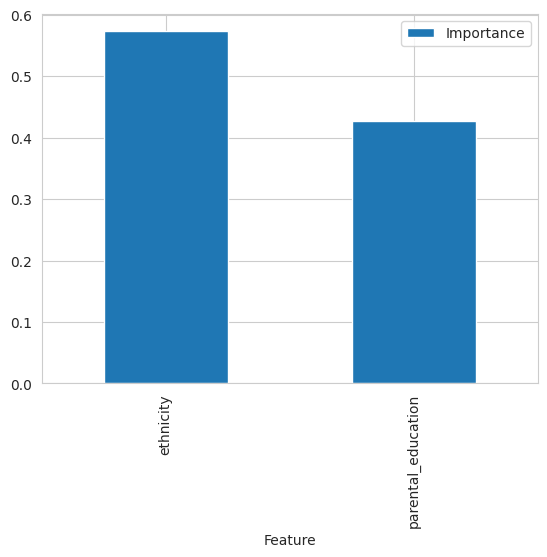

In [71]:
! rm outputs/ml_pipeline/predict_writing/v1/feature-importance-plot-writing.png

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature-importance-plot-writing.png', bbox_inches='tight')

Excellent - we have now trained a model for predicting a student's writing score. After requiring a classification task for the math_score and reading_score prediction tasks, we went straight for a classification method for the writing_score prediction task, reasoning that a regression model would offer poor performance.